In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pickle

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
train_df = pd.read_excel('datasets_140442_330428_Data_Train.xlsx', sheet_name='Sheet1')
test_df = pd.read_excel('datasets_140442_330428_Test_set.xlsx', sheet_name='Sheet1')

In [3]:
print(train_df.shape)
print(test_df.shape)

(10683, 11)
(2671, 10)


In [4]:
train_df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [5]:
train_df['Additional_Info'].unique()

# Here Additional info & Route  doesn't provide any value in predicting Price. hence removing this column.
remove_col = ['Additional_Info','Route']

In [6]:
train_df.info()

# Here price is only integer column and rest are object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [7]:
# we have only one missing record in dataset. Let's see the record. If possible will fill with valid info 
train_df[train_df['Route'].isnull()]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
9039,Air India,6/05/2019,Delhi,Cochin,NaN,09:45,09:25 07 May,23h 40m,NaN,No info,7480


In [8]:
# Flight departure time is 09:45 06th May,2019 and arrival time is 09:25 07th May,2019... We don't have any info of Route and Total_Stops. 
# As per knowledge, flight is having 1 stop. But not sure. Hence am removing this row.
train_df.dropna(axis=0, how='any', inplace=True)
# let's check flight price after removing null value
train_df.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
dtype: int64

In [9]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2671 entries, 0 to 2670
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          2671 non-null   object
 1   Date_of_Journey  2671 non-null   object
 2   Source           2671 non-null   object
 3   Destination      2671 non-null   object
 4   Route            2671 non-null   object
 5   Dep_Time         2671 non-null   object
 6   Arrival_Time     2671 non-null   object
 7   Duration         2671 non-null   object
 8   Total_Stops      2671 non-null   object
 9   Additional_Info  2671 non-null   object
dtypes: object(10)
memory usage: 208.8+ KB


# Feature Engineering

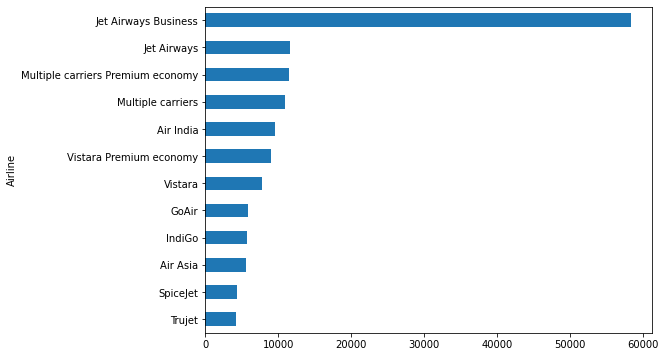

In [10]:
plt.figure(figsize=(8,6))
train_df.groupby('Airline')['Price'].mean().sort_values(ascending=True).plot(kind='barh')
plt.show()

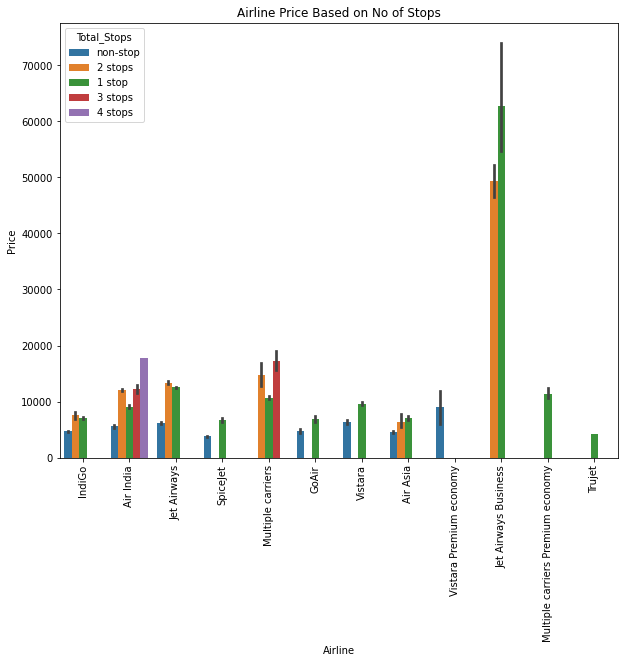

In [11]:
plt.figure(figsize=(10,8))
sns.barplot(x='Airline', y='Price', data=train_df, hue='Total_Stops')
plt.xticks(rotation=90)
plt.title('Airline Price Based on No of Stops')
plt.show()

**Insights:**

**Jet Airways airlines** fare price are relatively quite high compared with other airlines and **Trujet** & **Spicejet** Airlines are having less price.  

In [12]:
train_df['Destination'].unique()

array(['New Delhi', 'Banglore', 'Cochin', 'Kolkata', 'Delhi', 'Hyderabad'],
      dtype=object)

We can see that there are two different entry for Delhi. Let's update it to one.

In [13]:
train_df['Destination'] = train_df['Destination'].replace('New Delhi', 'Delhi')

**Date_of_Journey**

In [14]:
def date_of_journey_extract(flight_df):
  # Date_of_Journey column does have month and day information which will be kept in two separate columns.

  flight_df['Journey_Month'] = pd.to_datetime(flight_df['Date_of_Journey'], dayfirst=True).dt.month
  flight_df['Journey_Date'] = pd.to_datetime(flight_df['Date_of_Journey'], dayfirst=True).dt.day

  # Now we can drop this column.
  remove_col.append('Date_of_Journey')
  return flight_df

**Dep_Time**


In [15]:
def dep_time_extract(flight_df):
  # we will split this record in hour and minute column
  flight_df['Dep_Hour'] = pd.to_datetime(flight_df['Dep_Time']).dt.hour
  flight_df['Dep_Minute'] = pd.to_datetime(flight_df['Dep_Time']).dt.minute

  # let's drop this column
  remove_col.append('Dep_Time')
  return flight_df

**Arrival_Time**

In [16]:
def arrival_time_extract(flight_df):
  # we will extract hour and minute info from this column and will drop this at the end
  flight_df['Arrival_Hour'] = pd.to_datetime(flight_df['Arrival_Time']).dt.hour
  flight_df['Arrival_Minute'] = pd.to_datetime(flight_df['Arrival_Time']).dt.minute

  remove_col.append('Arrival_Time')
  return flight_df

**Duration**

In [17]:
def duration_extract(flight_df):
  #print(duration_list[0])
  flight_df['Duration'] = flight_df['Duration'].apply(lambda x: '0h '+x if 'h' not in x and 'm' in x else x+' 0m' if 'm' not in x and 'h' in x else x)
  flight_df['Duration_Hour'] = flight_df['Duration'].apply(lambda x: int(x.strip().split()[0].replace('h', '')))
  flight_df['Duration_Minute'] = flight_df['Duration'].apply(lambda x: int(x.strip().split()[1].replace('m', '')))
  remove_col.append('Duration')
  return flight_df

**Total_Stops**

In [18]:
def total_stop_manipulation(flight_df):
  # we will replace 'non-stop' as '0 stops' and then remove ' stops' word
  flight_df['Total_Stops'] = flight_df['Total_Stops'].replace('non-stop', '0 stops')
  flight_df['Total_Stops'] = flight_df['Total_Stops'].apply(lambda x: x.split()[0])
  flight_df['Total_Stops'] = pd.to_numeric(flight_df['Total_Stops'])
  # convert this column into integer
  # print(flight_df['Total_Stops'])
  return flight_df

In [19]:
def feature_remove(df, labels):
  df.drop(labels=labels, axis=1, inplace=True)
  return df

In [20]:
def feature_engineering_pipeline(df):
  df = date_of_journey_extract(df)
  df = dep_time_extract(df)
  df = arrival_time_extract(df)
  df = duration_extract(df)
  df = total_stop_manipulation(df)
  return df

In [21]:
train_df = feature_engineering_pipeline(train_df)
test_df = feature_engineering_pipeline(test_df)

In [22]:
print(train_df.shape)
print(test_df.shape)

(10682, 19)
(2671, 18)


In [23]:
# Copy of train_df and test_df
train_df_copy = train_df.copy(deep=True)
test_df_copy = test_df.copy(deep=True)

In [24]:
print(train_df.columns)
print(test_df.columns)

Index(['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route',
       'Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops',
       'Additional_Info', 'Price', 'Journey_Month', 'Journey_Date', 'Dep_Hour',
       'Dep_Minute', 'Arrival_Hour', 'Arrival_Minute', 'Duration_Hour',
       'Duration_Minute'],
      dtype='object')
Index(['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route',
       'Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops',
       'Additional_Info', 'Journey_Month', 'Journey_Date', 'Dep_Hour',
       'Dep_Minute', 'Arrival_Hour', 'Arrival_Minute', 'Duration_Hour',
       'Duration_Minute'],
      dtype='object')


# Categorical Data Handling

In [25]:
def oneHotEncoding(df, column):
  temp = pd.get_dummies(data= df[[column]], prefix=column, prefix_sep='_', drop_first=False)
  df = pd.concat([df, temp], axis=1)
  remove_col.append(column)
  return df

In [26]:
def categoricalDataHandling(data):
  data = oneHotEncoding(data, 'Source')
  data = oneHotEncoding(data, 'Destination')
  data = oneHotEncoding(data, 'Airline')
  data = feature_remove(data, list(set(remove_col)))
  return data


In [27]:
train_df = categoricalDataHandling(train_df)
test_df = categoricalDataHandling(test_df)

In [28]:
print(train_df.shape)
print(test_df.shape)

(10682, 32)
(2671, 31)


In [29]:
list1 = list(train_df.columns)
list2 = list(test_df.columns)

In [30]:
set(list1)-set(list2)

{'Airline_Trujet', 'Price'}

# Feature Selection

Finding out the best features which will contribute and have good relation with our Target variable.

Following are some feature selection methods: 1) heatmap 2) featureimportance 3) SelectKBest

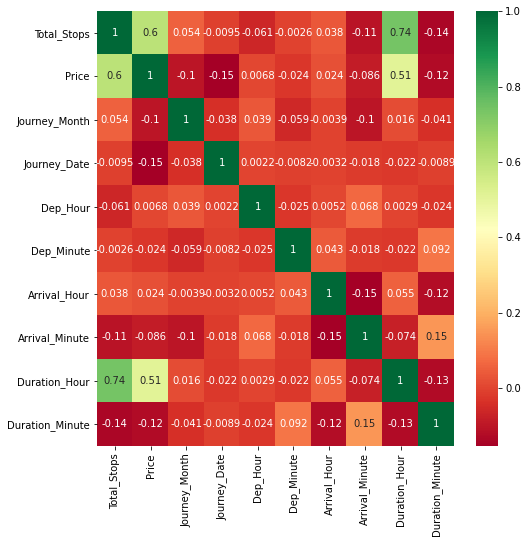

In [31]:
corr = train_df_copy.corr()
plt.figure(figsize=(8,8))
sns.heatmap(corr, annot=True, cmap='RdYlGn')
plt.show()

In [32]:
selection = ExtraTreesRegressor()

In [33]:
train_df.head(3)

,Total_Stops,Price,Journey_Month,Journey_Date,Dep_Hour,Dep_Minute,Arrival_Hour,Arrival_Minute,Duration_Hour,Duration_Minute,Source_Banglore,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Banglore,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Airline_Air Asia,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy
0,0,3897,3,24,22,20,1,10,2,50,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,2,7662,5,1,5,50,13,15,7,25,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,2,13882,6,9,9,25,4,25,19,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [34]:
x = train_df.drop('Price', axis=1)
y = train_df['Price']
selection.fit(x,y)

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=None, oob_score=False,
                    random_state=None, verbose=0, warm_start=False)

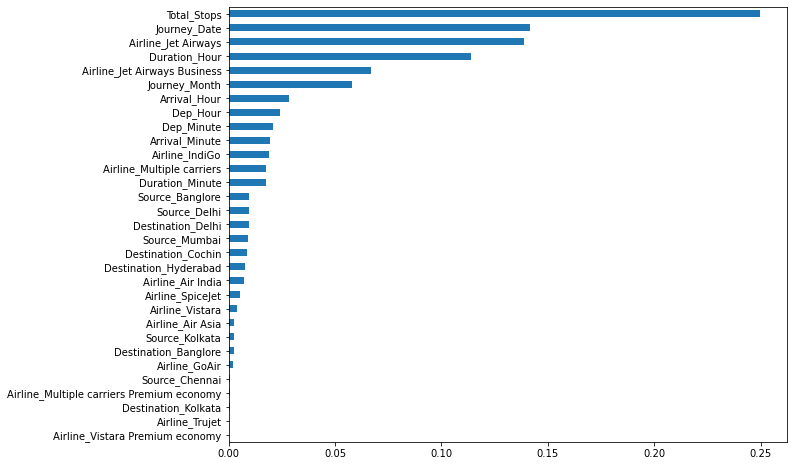

In [35]:
importance = pd.Series(selection.feature_importances_)
importance.index = x.columns
#features = list(train_df.columns)
plt.figure(figsize=(10,8))
importance.sort_values(ascending=True).plot(kind='barh')
plt.show()
#feature_importance = pd.DataFrame()

# Split data on train and test

In [36]:
train_x, test_x, train_y, test_y = train_test_split(x, y, random_state= 0, test_size=0.2)

# **Create Model**

In [37]:
def metrics_calculation(model, train_x, test_x, train_y, test_y):
  yhat = model.predict(test_x)
  print('Train Score : ',model.score(train_x, train_y))
  print('Test Score :',model.score(test_x, test_y))
  mae = mean_absolute_error(test_y, yhat)
  mse = mean_squared_error(test_y, yhat)
  rmse = np.sqrt(mse)
  r_squared = r2_score(test_y, yhat)
  adjusted_r2 = 1 - (1-r_squared)*(len(test_y)-1)/(len(test_y)-test_x.shape[1]-1)
  print('MAE : ', mae)
  print('MSE : ', mse)
  print('RMSE : ', rmse)
  print('R-Squared : ', r_squared)
  print('Adjusted R^2 : ',adjusted_r2)
  return mae, mse, rmse, r_squared, adjusted_r2


In [38]:
# RandomForest Model
RF = RandomForestRegressor()
RF.fit(train_x,train_y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [39]:
rf_mae, rf_mse, rf_rmse, rf_r_squared, rf_adjusted_r2 = metrics_calculation(RF, train_x, test_x, train_y, test_y)
#predict = model.predict(test_x)

Train Score :  0.9545087774715397
Test Score : 0.8125469165671704
MAE :  1244.358249971406
MSE :  4398244.494959549
RMSE :  2097.1992024983106
R-Squared :  0.8125469165671704
Adjusted R^2 :  0.809786324839656


**Comment:**

By analyzing R-Squared and Adjusted R^2 value, we can tell that model is not overfitted.

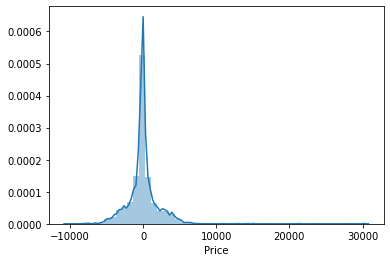

In [40]:
predict = RF.predict(test_x)
sns.distplot(test_y - predict)
plt.show()

It shows a Standard Normal distribution (Gaussian Distribution) which means the prediction is good here.

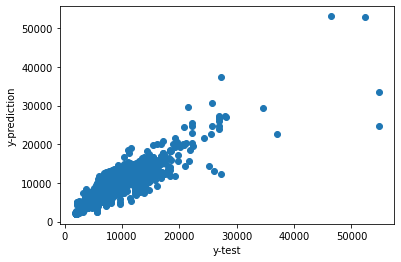

In [41]:
plt.scatter(test_y, predict)
plt.xlabel('y-test')
plt.ylabel('y-prediction')
plt.show()

The linear distribution in our scatter plot shows that our prediction is also going good.

In [42]:
# XGBoost Regressor
xgb = XGBRegressor()
xgb.fit(train_x, train_y)


[06:27:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [43]:
xgb_mae, xgb_mse, xgb_rmse, xgb_r_squared, xgb_adjusted_r2 = metrics_calculation(xgb, train_x, test_x, train_y, test_y)

Train Score :  0.7791359728027453
Test Score : 0.7421257744954605
MAE :  1611.5858563863624
MSE :  6050548.072866006
RMSE :  2459.786184379855
R-Squared :  0.7421257744954606
Adjusted R^2 :  0.7383281018158212


In [44]:
# LinearRegression
linear = LinearRegression()
linear.fit(train_x, train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [45]:
linear_mae, linear_mse, linear_rmse, linear_r_squared, linear_adjusted_r2 = metrics_calculation(linear, train_x, test_x, train_y, test_y)

Train Score :  0.6198543220166426
Test Score : 0.5759408293689392
MAE :  2056.657379954785
MSE :  9949774.517491495
RMSE :  3154.3263175346165
R-Squared :  0.5759408293689392
Adjusted R^2 :  0.569695777449907


In [46]:
# Support Vector Regressor
svr = SVR()
svr.fit(train_x, train_y)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [47]:
svr_mae, svr_mse, svr_rmse, svr_r_squared, svr_adjusted_r2 = metrics_calculation(svr, train_x, test_x, train_y, test_y)

Train Score :  0.00408843758632782
Test Score : -0.005161726235910047
MAE :  3667.606013685696
MSE :  23584285.45426032
RMSE :  4856.365457238604
R-Squared :  -0.005161726235910047
Adjusted R^2 :  -0.019964583011830683


In [48]:
# HistGradientBoostingRegressor
histgbregressor = HistGradientBoostingRegressor()
histgbregressor.fit(train_x, train_y)

HistGradientBoostingRegressor(l2_regularization=0.0, learning_rate=0.1,
                              loss='least_squares', max_bins=255,
                              max_depth=None, max_iter=100, max_leaf_nodes=31,
                              min_samples_leaf=20, n_iter_no_change=None,
                              random_state=None, scoring=None, tol=1e-07,
                              validation_fraction=0.1, verbose=0,
                              warm_start=False)

In [49]:
histgbregressor_mae, histgbregressor_mse, histgbregressor_rmse, histgbregressor_r_squared, histgbregressor_adjusted_r2 = metrics_calculation(histgbregressor, train_x, test_x, train_y, test_y)

Train Score :  0.8725039067901491
Test Score : 0.7784603649784543
MAE :  1336.486795014386
MSE :  5198023.21895662
RMSE :  2279.917371080939
R-Squared :  0.7784603649784544
Adjusted R^2 :  0.7751977860303936


In [50]:
model_param = {'model': ['Random Forest','XGBoost Regressor','Linear Regression','SVM Regressor', 'Hist GB Regressor'],
               'RMSE': [rf_rmse, xgb_rmse, linear_rmse, svr_rmse, histgbregressor_rmse],
               'R-Squared': [rf_r_squared, xgb_r_squared, linear_r_squared, svr_r_squared, histgbregressor_r_squared]}

model_comparison = pd.DataFrame(model_param)
model_comparison

,model,RMSE,R-Squared
0,Random Forest,2097.199202,0.812547
1,XGBoost Regressor,2459.786184,0.742126
2,Linear Regression,3154.326318,0.575941
3,SVM Regressor,4856.365457,-0.005162
4,Hist GB Regressor,2279.917371,0.778460


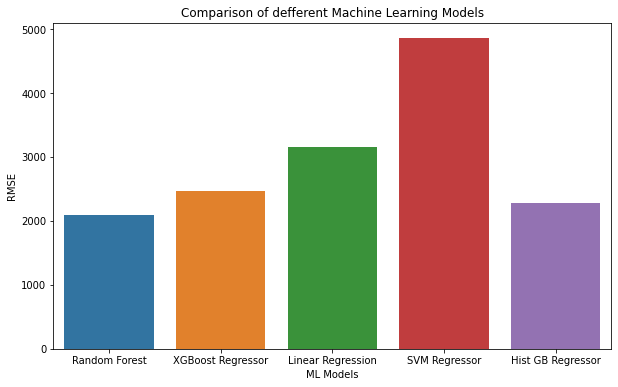

In [51]:
plt.figure(figsize=(10,6))
sns.barplot(x='model', y='RMSE', data = model_comparison)
plt.title('Comparison of defferent Machine Learning Models')
plt.xlabel('ML Models')
plt.ylabel('RMSE')
plt.show()

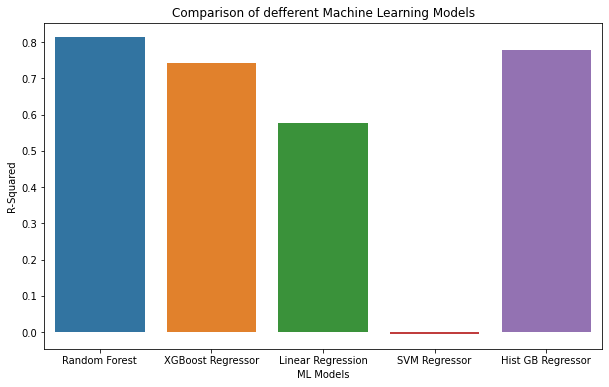

In [52]:
plt.figure(figsize=(10,6))
sns.barplot(x='model', y='R-Squared', data = model_comparison)
plt.title('Comparison of defferent Machine Learning Models')
plt.xlabel('ML Models')
plt.ylabel('R-Squared')
plt.show()

**We can see that Random Forest performs well here.**

# **Hyper Tuning**

There are two techniques of Hyperparameter tuning i.e 1) RandomizedSearchCv 2) GridSearchCV 

We use RandomizedSearchCv because it is much faster than GridSearchCV

In [53]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]

param_grid = {
    'n_estimators':n_estimators,
    'max_features':max_features,
    'max_depth':max_depth,
    'min_samples_split':min_samples_split,
    'min_samples_leaf':min_samples_leaf
}

In [54]:
random_cv = RandomizedSearchCV(estimator=RF, cv=5, random_state=10, param_distributions = param_grid, n_iter=10, 
                   verbose=2, n_jobs=-1, scoring='neg_mean_squared_error')

In [55]:
print(train_x.columns)

Index(['Total_Stops', 'Journey_Month', 'Journey_Date', 'Dep_Hour',
       'Dep_Minute', 'Arrival_Hour', 'Arrival_Minute', 'Duration_Hour',
       'Duration_Minute', 'Source_Banglore', 'Source_Chennai', 'Source_Delhi',
       'Source_Kolkata', 'Source_Mumbai', 'Destination_Banglore',
       'Destination_Cochin', 'Destination_Delhi', 'Destination_Hyderabad',
       'Destination_Kolkata', 'Airline_Air Asia', 'Airline_Air India',
       'Airline_GoAir', 'Airline_IndiGo', 'Airline_Jet Airways',
       'Airline_Jet Airways Business', 'Airline_Multiple carriers',
       'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet',
       'Airline_Trujet', 'Airline_Vistara', 'Airline_Vistara Premium economy'],
      dtype='object')


In [56]:
random_cv.fit(train_x, train_y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  5.4min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [57]:
random_cv.best_params_

{'max_depth': 25,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 600}

In [58]:
random_cv.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=25, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      n_estimators=600, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [59]:
final_model = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=25, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      n_estimators=600, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

final_model.fit(x, y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=25, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      n_estimators=600, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [60]:
print('Total no of columns : ', len(x.columns))
print('\n\nColumns : ', x.columns)

Total no of columns :  31


Columns :  Index(['Total_Stops', 'Journey_Month', 'Journey_Date', 'Dep_Hour',
       'Dep_Minute', 'Arrival_Hour', 'Arrival_Minute', 'Duration_Hour',
       'Duration_Minute', 'Source_Banglore', 'Source_Chennai', 'Source_Delhi',
       'Source_Kolkata', 'Source_Mumbai', 'Destination_Banglore',
       'Destination_Cochin', 'Destination_Delhi', 'Destination_Hyderabad',
       'Destination_Kolkata', 'Airline_Air Asia', 'Airline_Air India',
       'Airline_GoAir', 'Airline_IndiGo', 'Airline_Jet Airways',
       'Airline_Jet Airways Business', 'Airline_Multiple carriers',
       'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet',
       'Airline_Trujet', 'Airline_Vistara', 'Airline_Vistara Premium economy'],
      dtype='object')


In [61]:
final_predict = final_model.predict(test_x)

In [62]:
print('Train Score : ',final_model.score(train_x, train_y))
print('Test Score : ',final_model.score(test_x, test_y))

Train Score :  0.9163760872830761
Test Score :  0.9078238146543397


In [63]:
print('Mean Absolute Error : ', mean_absolute_error(test_y, final_predict))
print('Mean Squared Error : ', mean_squared_error(test_y, final_predict))
print('Root Mean Squar Error : ', np.sqrt(mean_squared_error(test_y, final_predict)))
print('R^2 Error : ',r2_score(test_y, final_predict))

Mean Absolute Error :  852.6472839819387
Mean Squared Error :  2162745.9646893134
Root Mean Squar Error :  1470.6277451106766
R^2 Error :  0.9078238146543397


It's clearly seen that after hyper tuning performance got increased by 2%.

# Model Save



In [64]:
filename = 'finalized_model.pkl'
pickle.dump(final_model, open(filename, 'wb'))